In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from cost_structures import CostStructure
from inventory_states import NonPerishableInventoryState
from policies import *

SEED = 0
np.random.seed(SEED)

Inventory state initialization

In [2]:
nb_products = 1
lead_times = np.zeros(nb_products,dtype=int)
state = NonPerishableInventoryState(nb_products,lead_times,"LOST_SALES")

Demand generator definition

In [3]:
demand_rvs = [scipy.stats.uniform(loc=0,scale=100) for k in range(nb_products)]
def demands_generator() :
    yield np.array([demand_rvs[k].rvs() for k in range(nb_products)])

Costs initialization

In [4]:
fixed_costs = np.zeros(nb_products)
purchase_costs = np.random.lognormal(0,size=nb_products)
holding_costs = np.random.lognormal(0,size=nb_products)
stockout_costs = np.random.lognormal(2,size=nb_products)
cost_structure = CostStructure(nb_products,fixed_costs,purchase_costs,holding_costs,stockout_costs)

Policies initialization

In [5]:
policies : List[AbstractInventoryPolicy] = [
    OptimalLostSalesPolicy(nb_products, purchase_costs, holding_costs, stockout_costs, discount_factor=1.0, demand_quantile_functions=[demand_rvs[k].ppf for k in range(nb_products)]),
    ConstantOrderQuantity([demand_rvs[k].mean() for k in range(nb_products)]),
    ConstantOrderQuantity(np.zeros(nb_products))
]
policy_names = [
    "OptimalUnconstrained", 
    "MeanDemandOrderQuantity",
    "ZeroOrders"
]

Optimal unconstrainted base-stock level: [90.26007797]


In [15]:
nb_periods = 100
state.reset()
cost_structure.reset()
for policy_id in tqdm(range(len(policies))) : 
    for t in tqdm(range(1,nb_periods+1)) :
        order_quantities = policies[policy_id].get_order_quantity(t,state)
        demands = next(demands_generator())
        state.step(t,order_quantities,demands)
        cost_structure.incur_cost(t,state,order_quantities)
    cost_structure.save_history_as_csv("costs_{}.csv".format(policy_id))
    state.save_movements_as_csv("movements_{}.csv".format(policy_id))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

# Results

Aggregated costs

In [12]:
for policy_id in range(len(policies)) :
    print("\nPolicy {}".format(policy_names[policy_id]))
    print(pd.read_csv("cost_histories/costs_{}.csv".format(policy_id))[["purchase_cost","holding_cost","stockout_cost"]].sum())
    print("Total cost: {:e}".format(pd.read_csv("cost_histories/costs_{}.csv".format(policy_id))[["purchase_cost","holding_cost","stockout_cost"]].sum().sum()))


Policy OptimalUnconstrained
purchase_cost    28940.381494
holding_cost      6097.274472
stockout_cost      735.380969
dtype: float64
Total cost: 3.577304e+04

Policy MeanDemandOrderQuantity
purchase_cost    29180.195953
holding_cost     25634.380238
stockout_cost        0.000000
dtype: float64
Total cost: 5.481458e+04

Policy ZeroOrders
purchase_cost        0.000000
holding_cost        93.948608
stockout_cost    98990.841850
dtype: float64
Total cost: 9.908479e+04


Cumulative total cost

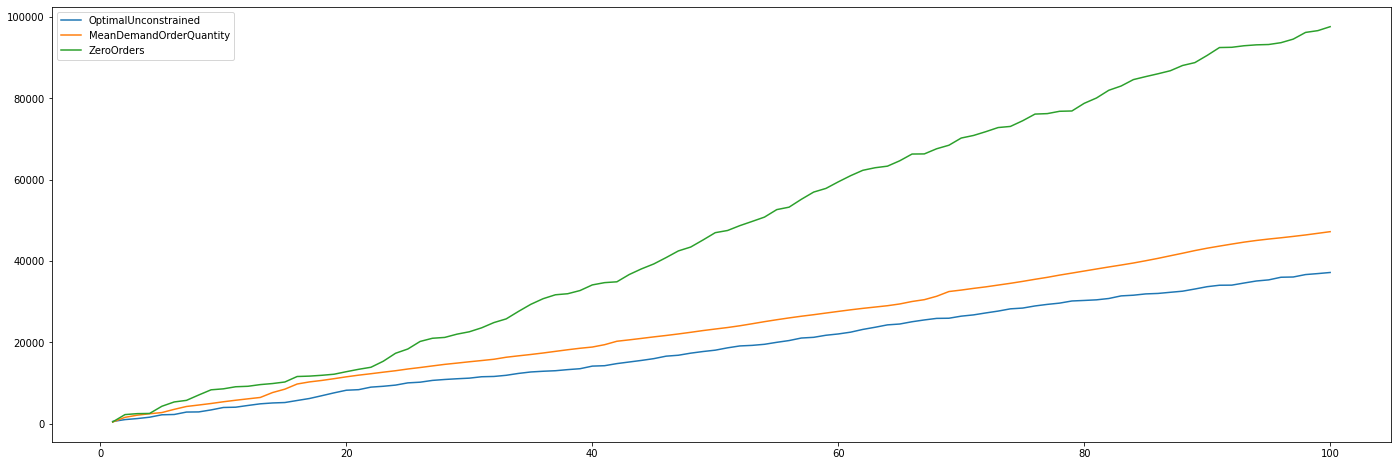

In [16]:
plt.figure(figsize=(24,8))
for policy_id in range(len(policies)) :
    plt.plot(pd.read_csv("cost_histories/costs_{}.csv".format(policy_id)).groupby("period").sum().sum(axis=1).cumsum(),label=policy_names[policy_id])
plt.legend()
plt.show()

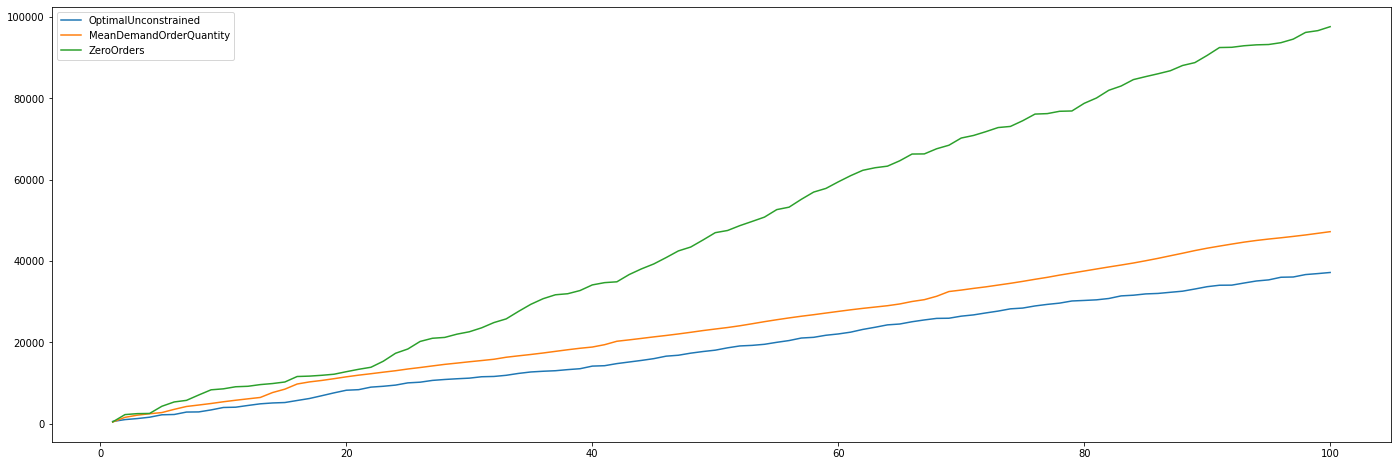

In [18]:
plt.figure(figsize=(24,8))
for policy_id in range(len(policies)) :
    plt.plot(pd.read_csv("cost_histories/costs_{}.csv".format(policy_id)).groupby("period").sum().sum(axis=1).cumsum(),label=policy_names[policy_id])
plt.legend()
plt.show()

Cumulative holding cost

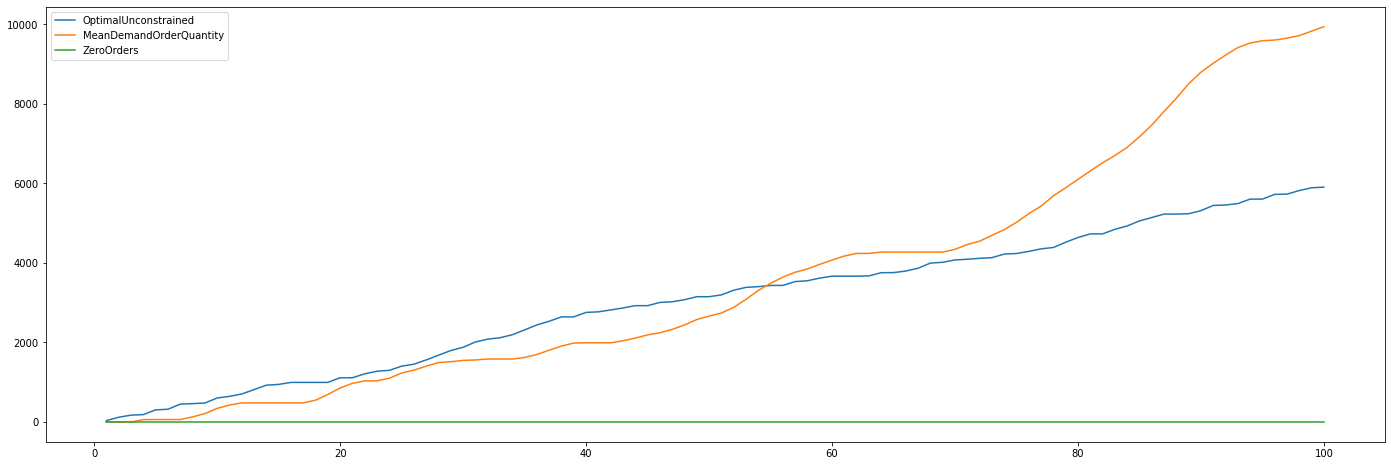

In [21]:
plt.figure(figsize=(24,8))
for policy_id in range(len(policies)) :
    plt.plot(pd.read_csv("cost_histories/costs_{}.csv".format(policy_id)).groupby("period").sum()["holding_cost"].cumsum(),label=policy_names[policy_id])
plt.legend()
plt.show()

Cumulative stockout cost

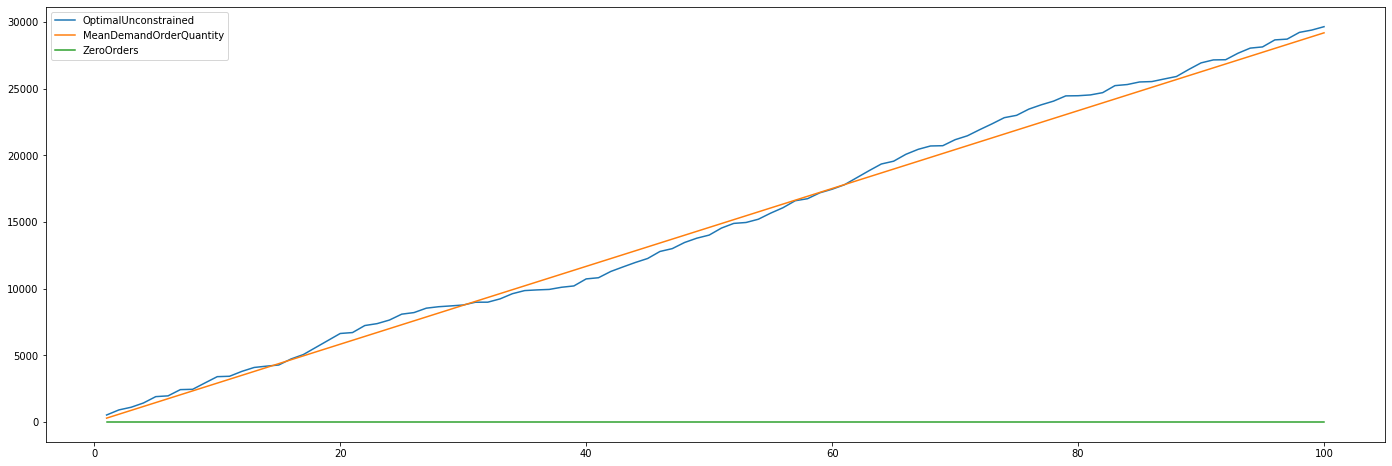

In [20]:
plt.figure(figsize=(24,8))
for policy_id in range(len(policies)) :
    plt.plot(pd.read_csv("cost_histories/costs_{}.csv".format(policy_id)).groupby("period").sum()["purchase_cost"].cumsum(),label=policy_names[policy_id])
plt.legend()
plt.show()